# GNN实例

## 实例一

In [ ]:
import os
import json
import scipy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

### 数据输入

In [2]:
# (node, label)集
N = [("n{}".format(i), 0) for i in range(1,7)] + \
    [("n{}".format(i), 1) for i in range(7,13)] + \
    [("n{}".format(i), 2) for i in range(13,19)]
# 边集
E = [("n1","n2"), ("n1","n3"), ("n1","n5"),
     ("n2","n4"),
     ("n3","n6"), ("n3","n9"),
     ("n4","n5"), ("n4","n6"), ("n4","n8"),
     ("n5","n14"),
     ("n7","n8"), ("n7","n9"), ("n7","n11"),
     ("n8","n10"), ("n8","n11"), ("n8", "n12"),
     ("n9","n10"), ("n9","n14"),
     ("n10","n12"),
     ("n11","n18"),
     ("n13","n15"), ("n13","n16"), ("n13","n18"),
     ("n14","n16"), ("n14","n18"),
     ("n15","n16"), ("n15","n18"),
     ("n17","n18")]

### 数据Graph显示

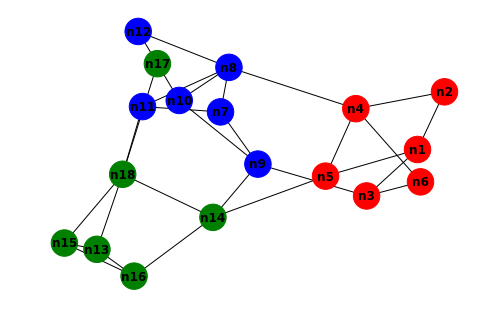

In [3]:
# [WARNING] Please downgrade matplotlib to matplotlib==2.2.3

# 构建Graph
G = nx.Graph()
G.add_nodes_from(list(map(lambda x: x[0], N)))
G.add_edges_from(E)
# 设置Graph显示属性，包括颜色，形状，大小
ncolor = ['r'] * 6 + ['b'] * 6 + ['g'] * 6
nsize = [700] * 6 + [700] * 6 + [700] * 6
# 显示Graph
plt.figure(1)
nx.draw(G, with_labels=True, font_weight='bold', 
        node_color=ncolor, node_size=nsize)
# plt.savefig("./images/graph.png")

### 模型构建

In [4]:
class Xi(nn.Module):
    """实现Xi函数，输入一个batch的相邻节点特征向量对ln，返回是s*s的A矩阵"""
    def __init__(self, ln, s):
        super(Xi, self).__init__()
        self.ln = ln   # 节点特征向量的维度
        self.s = s     # 节点的个数
        
        # 线性网络层
        self.linear = nn.Linear(in_features=2 * ln,
                                out_features=s ** 2,
                                bias=True)
        # 激活函数
        self.tanh = nn.Tanh()
        
    def forward(self, X):
        """
        :param X: (N, 2*ln)，输入的节点特征及邻居节点特征concat。
        :return out: (N, S, S)，输出用于线性变换的参数矩阵。
        """
        bs = X.size()[0]
        out = self.linear(X)
        out = self.tanh(out)
        out = out.view(bs, self.s, self.s)
        return out

# 实现Rou函数
# Input : (N, ln)
# Output : (N, S)
class Rou(nn.Module):
    def __init__(self, ln, s):
        super(Rou, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_features=ln, out_features=s, bias=True),
            nn.Tanh()
        )
        
    def forward(self, X):
        out = self.linear(X)
        return out


# 实现Hw函数
class Hw(nn.Module):
    def __init__(self, ln, s, mu=0.9):
        super(Hw, self).__init__()
        self.ln = ln
        self.s = s
        self.mu = mu
        
        # 初始化网络层
        self.Xi = Xi(ln, s)
        self.Rou = Rou(ln, s)
    
    def forward(self, X, H, dg_list):
        """
        :param X: (N, 2 * ln)，一个节点特征向量和该节点的某一个邻接向量concat得到的向量
        :param H: (N, s)，对应中心节点的状态向量
        :param dg_list: (N, )，对应中心节点的度的向量
        :return out: (N, s)
        """
        if type(dg_list) == list:
            dg_list = torch.Tensor(dg_list)
        elif isinstance(dg_list, torch.Tensor):
            pass
        else:
            raise TypeError("==> dg_list should be list or tensor, not {}".format(type(dg_list)))
        
        A = (self.Xi(X) * self.mu / self.s) / dg_list.view(-1, 1, 1) # (N, S, S)
        b = self.Rou(torch.chunk(X, chunks=2, dim=1)[0]) # (N, S)
        out = torch.squeeze(torch.matmul(A, torch.unsqueeze(H, 2)),-1) + b  # (N, s, s) * (N, s) + (N, s)
        return out    # (N, s)

class AggrSum(nn.Module):
    def __init__(self, node_num):
        super(AggrSum, self).__init__()
        self.V = node_num
    
    def forward(self, H, X_node):
        # H : (N, s) -> (V, s)
        # X_node : (N, )
        mask = torch.stack([X_node] * self.V, 0)
        mask = mask.float() - torch.unsqueeze(torch.range(0,self.V-1).float(), 1)
        mask = (mask == 0).float()
        # (V, N) * (N, s) -> (V, s)
        return torch.mm(mask, H)

# 实现GNN模型
class OriLinearGNN(nn.Module):
    """根据论文`The graph neural network model`构建的LinearGNN模型。"""
    def __init__(self, node_num, feat_dim, stat_dim, T):
        """
        初始化模型函数。
        
        :param node_num: 节点数量
        :param feat_dim: 节点特征维度
        :param stat_dim: 节点状态维度
        :param T       : GNN更新轮数
        """
        super(OriLinearGNN, self).__init__()
        self.node_num = node_num
        self.embed_dim = feat_dim
        self.stat_dim = stat_dim
        self.T = T
        
        # 初始化节点的embedding，即节点特征向量 (V, ln)
        self.node_features = nn.Parameter(
            data=torch.randn((self.node_num, self.embed_dim), dtype=torch.float32),
            requires_grad = True)
        
        # 输出层
        self.linear = nn.Linear(feat_dim+stat_dim, 3)
        self.softmax = nn.Softmax()
        
        # 实现Fw
        self.Hw = Hw(feat_dim, stat_dim)
        # 实现H的分组求和
        self.Aggr = AggrSum(node_num)
        
    def forward(self, X_Node, X_Neis, dg_list):
        """前向计算函数。值得注意的是，这里输入的X_Node和N_Neis的第一个维度`N`表示边的个数。
        比如：
            X_Node: [0, 0, 0, 1, 1, ..., 18, 18]
            X_Neis: [1, 2, 4, 1, 4, ..., 11, 13]
        :param X_Node: 节点索引
        :param X_Neis: X_node对应节点邻居的索引
        :param dg_list: 节点的度列表
        """
        
        node_embeds = self.node_features[X_Node]  # (N, ln)
        neis_embeds = self.node_features[X_Neis]  # (N, ln)
        X = torch.cat((node_embeds, neis_embeds), 1)  # (N, 2 * ln)
        
        # 初始化节点的状态向量 (V, s)
        node_states = Variable(torch.zeros((self.node_num, self.stat_dim), dtype=torch.float32),
                               requires_grad = False)
        # 循环T次计算
        for t in range(self.T):
            # (V, s) -> (N, s)
            H = torch.index_select(node_states, 0, X_Node)
            # (N, s) -> (N, s)
            H = self.Hw(X, H, dg_list)
            # (N, s) -> (V, s)
            node_states = self.Aggr(H, X_Node)
            
        out = self.linear(torch.cat((self.node_features.data, node_states), 1))
        out = self.softmax(out)
        return out  # (V, 3)

### 模型训练和评估

In [5]:
def CalAccuracy(output, label):
    # output : (N, C)
    # label : (N)
    out = np.argmax(output, axis=1)
    res = out - label
    return list(res).count(0) / len(res)

# 开始训练模型
def train(node_list, edge_list, label_list, T, ndict_path="./node_dict.json"):
    # 生成node-index字典
    if os.path.exists(ndict_path):
        with open(ndict_path, "r") as fp:
            node_dict = json.load(fp)
    else:
        node_dict = dict([(node, ind) for ind, node in enumerate(node_list)])
        node_dict = {"stoi" : node_dict,
                     "itos" : node_list}
        with open(ndict_path, "w") as fp:
            json.dump(node_dict, fp)

    # 现在需要生成两个向量
    # 第一个向量类似于
    #   [0, 0, 0, 1, 1, ..., 18, 18]
    # 其中的值表示节点的索引，连续相同索引的个数为该节点的度
    # 第二个向量类似于
    #   [1, 2, 4, 1, 4, ..., 11, 13]
    # 与第一个向量一一对应，表示第一个向量节点的邻居节点

    # 首先统计得到节点的度
    Degree = dict()
    for n1, n2 in edge_list:
        # 边的第一个节点的邻接节点为第二个节点
        if n1 in Degree:
            Degree[n1].add(n2)
        else:
            Degree[n1] = {n2}
        # 边的第二个节点的邻接节点为第一个节点
        if n2 in Degree:
            Degree[n2].add(n1)
        else:
            Degree[n2] = {n1}
    
    # 然后生成两个向量
    node_inds = []
    node_neis = []
    for n in node_list:
        node_inds += [node_dict["stoi"][n]] * len(Degree[n])
        node_neis += list(map(lambda x: node_dict["stoi"][x],list(Degree[n])))
    
    # 生成度向量
    dg_list = list(map(lambda x: len(Degree[node_dict["itos"][x]]), node_inds))
    
    # 准备训练集和测试集
    train_node_list = [0,1,2,6,7,8,12,13,14]
    train_node_label = [0,0,0,1,1,1,2,2,2]
    test_node_list = [3,4,5,9,10,11,15,16,17]
    test_node_label = [0,0,0,1,1,1,2,2,2]
    
    # 开始训练
    model = OriLinearGNN(node_num=len(node_list),
                         feat_dim=2,
                         stat_dim=2,
                         T=T)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss(size_average=True)
    
    min_loss = float('inf')
    train_loss_list = []
    train_acc_list = []
    test_acc_list = []
    node_inds_tensor = Variable(torch.Tensor(node_inds).long())
    node_neis_tensor = Variable(torch.Tensor(node_neis).long())
    train_label = Variable(torch.Tensor(train_node_label).long())
    for ep in range(500):
        # 运行模型得到结果
        with torch.autograd.set_detect_anomaly(True):
            res = model(node_inds_tensor, node_neis_tensor, dg_list) # (V, 3)
            train_res = torch.index_select(res, 0, torch.Tensor(train_node_list).long())
            test_res = torch.index_select(res, 0, torch.Tensor(test_node_list).long())
            loss = criterion(input=train_res,
                             target=train_label)
            loss_val = loss.item()
            train_acc = CalAccuracy(train_res.cpu().detach().numpy(), np.array(train_node_label))
            test_acc = CalAccuracy(test_res.cpu().detach().numpy(), np.array(test_node_label))
            # 更新梯度
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
        # 保存loss和acc
        train_loss_list.append(loss_val)
        test_acc_list.append(test_acc)
        train_acc_list.append(train_acc)
        
        if loss_val < min_loss:
            min_loss = loss_val
        print("==> [Epoch {}] : loss {:.4f}, min_loss {:.4f}, train_acc {:.3f}, test_acc {:.3f}".format(ep, loss_val, min_loss, train_acc, test_acc))
    return train_loss_list, train_acc_list, test_acc_list

In [ ]:
train_loss, train_acc, test_acc = train(node_list=list(map(lambda x:x[0], N)),
                                        edge_list=E,
                                        label_list=list(map(lambda x:x[1], N)),
                                        T=5)

### 画出loss和acc曲线

In [ ]:
epochs = len(train_loss)
plt.figure()
# 画出train_loss
plt.subplot(3,1,1)
plt.plot(range(epochs), train_loss)
plt.xlim((0,epochs))    # 设置x轴的范围
plt.ylabel('loss')      # 设置y周标签
plt.yticks(np.arange(0,1.5,0.2))  # 设置y轴刻度

# 画出train_acc
plt.subplot(3,1,2)
plt.plot(range(epochs), train_acc)
plt.xlim((0,epochs))
plt.ylim((0,1))
plt.ylabel('train_acc')
plt.yticks(np.arange(0,1,0.1))
# 画出test_acc
plt.subplot(3,1,3)
plt.plot(range(epochs), test_acc)
plt.xlim((0,epochs))
plt.ylim((0,1))
plt.xlabel('epoch')
plt.ylabel('test_acc')
plt.yticks(np.arange(0,1,0.1))

# 保存图片
# plt.savefig("./images/result.png")